# Double Integrator SLQ

Run the Sequential Linear Quadratic algorithm on a double integrator model as a simple test of its performance.

*Note:* This will send draw commands to the Drake Visualizer, but you'll need to open it yourself from a separate terminal with `drake-visualizer`. 

In [1]:
# Add the current directory to the package search path, so we can "using Acrobots" later
push!(LOAD_PATH, ".")

5-element Array{ByteString,1}:
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/local/share/julia/site/v0.4"
 "/Applications/Julia-0.4.5.app/Contents/Resources/julia/share/julia/site/v0.4"      
 "/Users/rdeits/6.338/hw2"                                                           
 "/Users/rdeits/6.338/julia-mindstorms-mapping"                                      
 "."                                                                                 

In [2]:
# Load the packages we'll need.
# The syntax "import Foo: bar" translates to "load the module Foo 
# but only bring the type or function bar into the current workspace."
import PyPlot: plot
import FixedSizeArrays: Mat
using Acrobots

In [3]:
# Construct the robot
robot = Acrobots.double_integrator()

Acrobots.DoubleIntegrator{Float64}(1.0)

In [4]:
# Choose desired and initial states
xdes = Acrobots.DoubleIntegratorState{Float64}(1, 0)
x0 = Acrobots.DoubleIntegratorState{Float64}(0, 0)

Acrobots.DoubleIntegratorState{Float64}(0.0,0.0)

In [5]:
# Set up the cost functions
Qf = diagm([1.,1])
Rf = 1e-6*eye(1)
Qt = diagm([0, 0.])

function state_cost(state::Acrobots.DoubleIntegratorState)
    x = convert(Vector, state - xdes)
    return 0.5*(x' * Qt * x)[1]
end
function input_cost(input::Acrobots.DoubleIntegratorInput)
    return Rf[1,1] * 0.5*input.u^2
end

# Use Qf as the final cost-to-go when we run SLQ later
S_final = Mat(Qf)

FixedSizeArrays.Mat{2,2,Float64}(
    1.0 0.0
    0.0 1.0
)


In [6]:
# Linearize the system around x0 and construct an LQR controller for x0.
# This will serve as the initial stabilizing controller for SLQ. 
input = zero(Acrobots.DoubleIntegratorInput{Float64})
linear_sys = Acrobots.linearize(robot, 0, x0, input)
controller = Acrobots.lqr(linear_sys, Qf, Rf, x0)
controller_state = Acrobots.LQRState{Float64}(()) 
@assert length(controller_state) == 0 # LQR controller has no state

In [7]:
# Simulate the system and linearize it at every time point
dt = 0.001
ts = 0:dt:2
linearizations = Acrobots.simulate_and_linearize(robot, x0, controller, ts);

In [8]:
# Now run the SLQ algorithm:
#   * quadratize costs around the previous simulated trajectory
#   * compute a search direction by running the Ricatti-like differential 
#       equation backwards in time
#   * compute a new controller by stepping along the search direction by alpha
#   * simulate the system with the new controller

# Since this system is truly linear, we could just choose an alpha of 1.0 to 
# step immediately to the optimal result, but we'll use alpha = 0.5 here to
# show progress of the algorithm

alpha = 0.5

for i = 1:10
    Qs, qs, Rs, rs = Acrobots.quadratize_costs(robot, ts, linearizations, state_cost, input_cost)
    Ks, ls = Acrobots.search_direction(robot, ts, linearizations, Qs, qs, Rs, rs, S_final, xdes)
    controller = Acrobots.update_controller(robot, ts, linearizations, Ks, ls, alpha)
    linearizations = Acrobots.simulate_and_linearize(robot, x0, controller, ts)

    
end

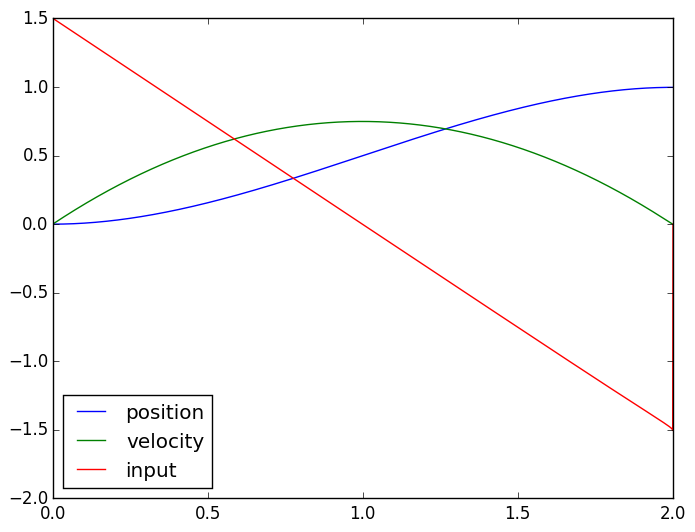

PyObject <matplotlib.legend.Legend object at 0x31d328450>

In [9]:
plot(ts, [lin.x0[1] for lin in linearizations], ts, [lin.x0[2] for lin in linearizations],
ts, [lin.u0[1] for lin in linearizations])
PyPlot.legend(["position", "velocity", "input"], loc="best")